# Predictive Analysis on Diabetes Patient Detection

### Created by Jidan Fikri



In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
import pandas as pd
import numpy as np
from scipy.stats import skew
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE

## Data Loading

In [2]:
# load dataset
path = kagglehub.dataset_download("uciml/pima-indians-diabetes-database")

print("Path to dataset files:", path)

100%|██████████| 8.91k/8.91k [00:00<00:00, 7.36MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/uciml/pima-indians-diabetes-database/versions/1


In [3]:
!mv '/root/.cache/kagglehub/datasets/uciml/pima-indians-diabetes-database/versions/1/diabetes.csv' '/content'

In [4]:
df = pd.read_csv('/content/diabetes.csv')
df.head()

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1

## Exploratory Data Analysis (EDA)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [6]:
df.describe()

Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  120.894531      69.105469      20.536458   79.799479   
std       3.369578   31.972618      19.355807      15.952218  115.244002   
min       0.000000    0.000000       0.000000       0.000000    0.000000   
25%       1.000000   99.000000      62.000000       0.000000    0.000000   
50%       3.000000  117.000000      72.000000      23.000000   30.500000   
75%       6.000000  140.250000      80.000000      32.000000  127.250000   
max      17.000000  199.000000     122.000000      99.000000  846.000000   

              BMI  DiabetesPedigreeFunction         Age     Outcome  
count  768.000000                768.000000  768.000000  768.000000  
mean    31.992578                  0.471876   33.240885    0.348958  
std      7.884160                  0.331329   11.760232    0.476951  
min      0.000000                  0.078000   21.000000    0.000000  
25%     27.300000                  0.243750   24.000000    0.000000  
50%     32.000000                  0.372500   29.000000    0.000000  
75%     36.600000                  0.626250   41.000000    1.000000  
max     67.100000                  2.420000   81.000000    1.000000

### Mengecek korelasi variabel dengan nilai null atau zero

Seperti yang terlihat pada hasil keluaran cell diatas, terdapat beberapa variabel yang memiliki nilai minimum 0 seperti pada variabel Pregnancies, Glucose, BloodPressure, SkinThickness, Insulin, dan BMI.

In [7]:
# Mencari nilai null/zero
df2 = df.iloc[:, :-1]
print("(Rows, Column): ", df2.shape)
print("\nKolom           # Jumlah null value\n")
print((df2[:] == 0).sum())

(Rows, Column):  (768, 8)

Kolom           # Jumlah null value

Pregnancies                 111
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
dtype: int64


Seperti yang terlihat, ada 6 variabel yang terdeteksi memiliki data dengan nilai null dengan variabel Insulin dan Skin Thickness menjadi 2 diantara yang terbesar. Dari keenam variabel tersebut, hanya 1 variabel yang sangat wajar untuk memiliki nilai nol, yaitu pregnancies atau kehamilan mengingat responden dari data ini yaitu wanita dengan umur berkisar diantara 21 - 81 tahun. \
 \
Adapun variabel seperti Glucose, BloodPressure, SkinThickness, Insulin, dan BMI berpotensi untuk menjadi anomali dikarenakan hal ini menyangkut kondisi kesehatan manusia, misalnya saja variabel BloodPressure atau tekanan darah, tentu jika value dari variabel ini bernilai nol maka orang tersebut tidak hidup bukan? \
\
Untuk itu perlu dilakukan analisis terkait korelasi dari data tersebut terhadap variabel target yaitu outcome, terlebih untuk kasus pada variabel SkinThickness dan Insulin dengan persentase tertinggi. Hal ini dilakukan untuk menganalisis adanya data leakage pada dataset yang digunakan.

Text(0.5, 1.0, 'Matrix Kolerasi Dataset Diabetes')

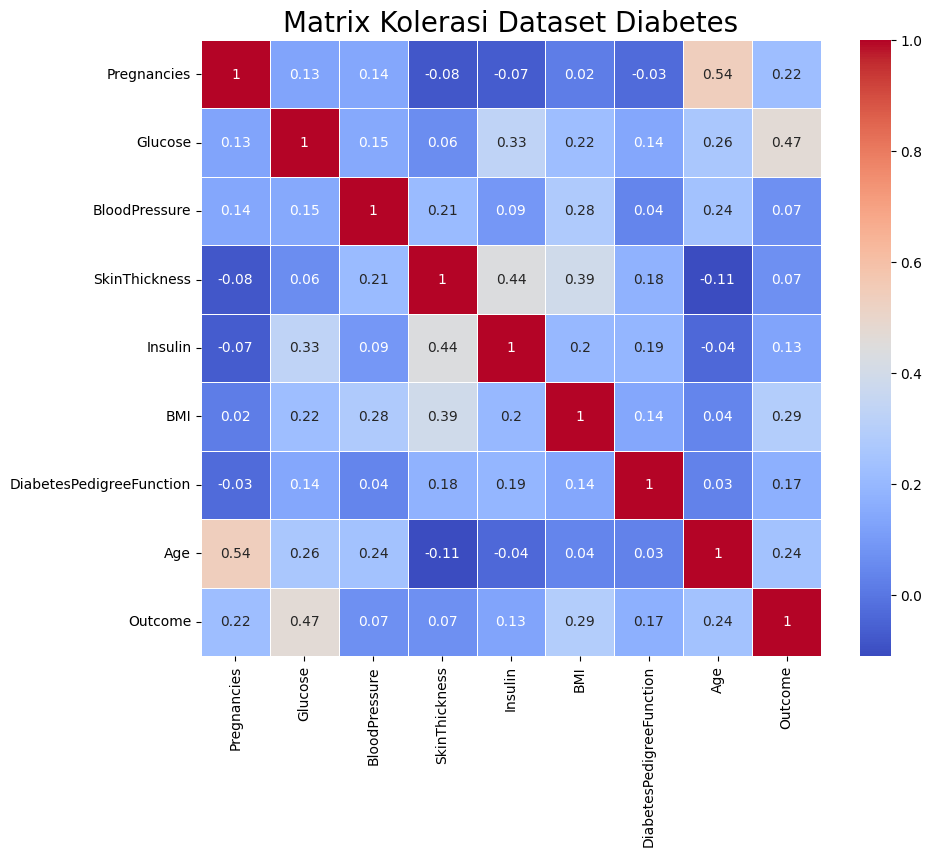

In [8]:
plt.figure(figsize=(10,8))
correlation_matrics = df.corr().round(2)
sns.heatmap(data=correlation_matrics, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Matrix Kolerasi Dataset Diabetes', size=20)

Korelasi antara variabel SkinThickness dan Insulin dengan variabel Outcome(diagnosis) memiliki nilai korelasi yang sangat rendah. Maka dari itu kekhawatiran akan data leakage terhadap 2 variabel tersebut dapat dikesampingkan. \

Meski korelasi dari kedua variabel ini rendah, dalam hal klinis kehadiran dari semua variabel dapat sangat kritikal dalam menentukan kondisi seseorang, termasuk salah satunya kehadiran informasi terkait kondisi insulin yang sangat dekat kaitannya dengan glukosa dalam darah. Berdasarkan hal tersebut, maka opsi yang paling tepat adalah melakukan imputasi terhadap value yang kosong tersebut daripada memotong kedua variabel tadi dari dataset yang akan kita gunakan. \

Selanjutnya, untuk memudahkan proses analisis, data bernilai nol dari variabel Glucose, BloodPressure, SkinThickness, Insulin, dan BMI akan diubah menjadi NaN. Hal ini juga dimaksudkan untuk membedakan antara kebedaraan data yang kosong dengan data yang memang memiliki nilai nol seperti pada variabel Prenancies.

In [9]:
# Mengubah value nol menjadi NaN untuk mengecualikan variabel Pregnancies yang bernilai nol
diabetes_df = df.copy(deep = True)
diabetes_df[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']] = diabetes_df[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']].replace(0,np.NaN)

# Mengecek keberadaan NaN
print(diabetes_df.isnull().sum())

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64


<ipython-input-10-96d7dcfd4140>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Outcome', data=diabetes_df, palette='hls')


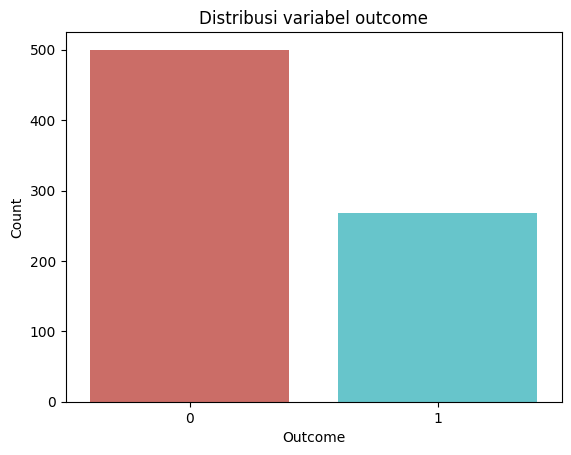

In [10]:
# Mengecek jumlah data pada variabel Outcome

sns.countplot(x='Outcome', data=diabetes_df, palette='hls')
plt.title('Distribusi variabel outcome')
plt.xlabel('Outcome')
plt.ylabel('Count')
plt.show()

Seperti yang terlihat pada histogram diatas bahwa dataset yang digunakan mengalami ketidakseimbangan pada label Outcome, dimana label 0 (Diagnosa pasien yang tidak memiliki diabetes) hampir 2 kali lipat lebih banyak dari label 1 (Diagnosa pasien yang memiliki diabetes). Untuk mengatasi hal ini, akan dilakukan tahapan transformasi berupa oversampling nantinya pada tahapan Data Preparation & Model Development setelah dataset di split menjadi data training dan testing. Adapun tahapan oversampling ini akan dilakukan hanya pada data training untuk menghindari adanya bias pada model yang akan dibuat.

### Data Skewness


Melihat distribusi data pada masing - masing variabel untuk mengecek skewness atau kondisi simetrikal dari distribusi data pada tiap variabelnya. Left-Skewness data merupakan data yang ketika diplot memiliki ekor lebih panjang di sisi kiri dan sebagian besar data terkonsentrasi di sisi kanan, sedangkan Right-Skewness data merupakan data yang ketika diplot memiliki ekor lebih panjang di sisi kanan dan sebagian besar data terkonsentrasi di sisi kiri. \

Skewness dapat memengaruhi analisis data karena pada metode statistik tertentu mengasumsikan distribusi data yang simetris sehingga dapat memengaruhi keakuratan hasil akurasi nantinya. Oleh karena itu, perlu dilakukan transformasi data untuk menyeimbangkan distribusi dan mengurangi skewness.

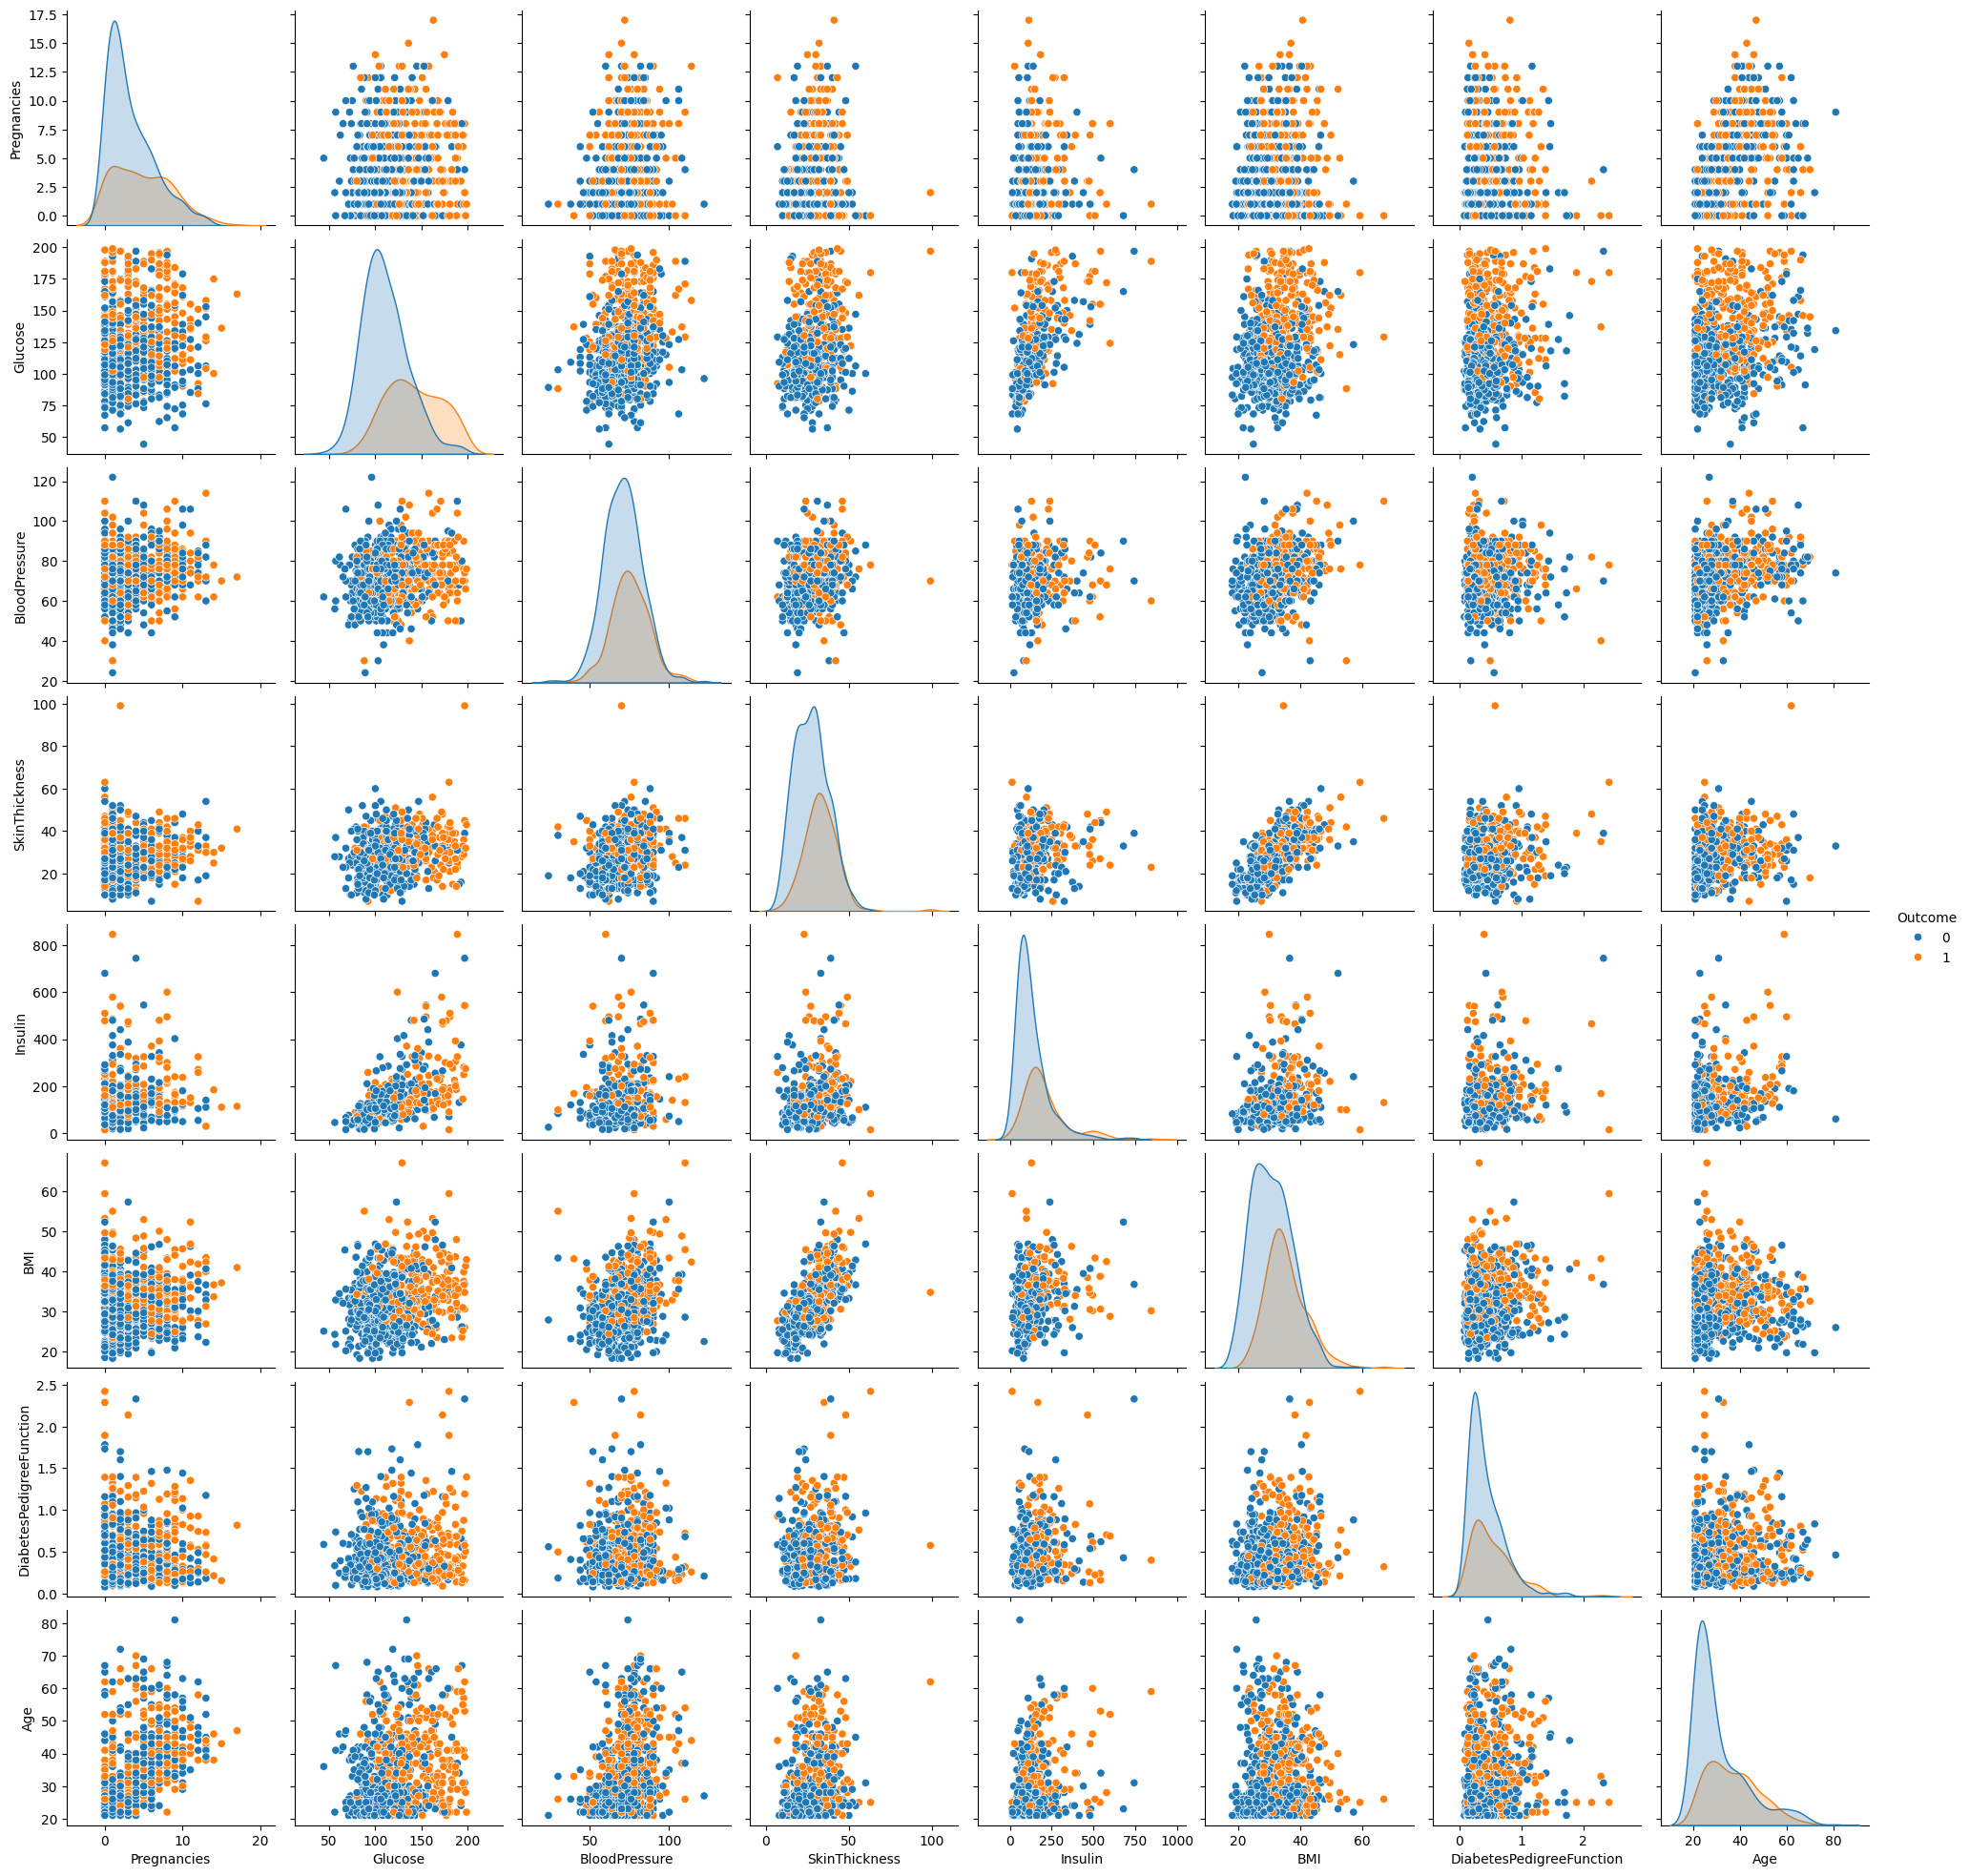

In [11]:
# pairplot menggunakan original data
p=sns.pairplot(diabetes_df, hue = 'Outcome')

In [12]:
for col in diabetes_df.columns:
    skewness = skew(diabetes_df[col], nan_policy='omit')
    print(f"{col}: {skewness}")

Pregnancies: 0.8999119408414357
Glucose: 0.5299440812657646
BloodPressure: 0.13387804741721232
SkinThickness: 0.6887026971544089
Insulin: 2.1582071470271136
BMI: 0.5927921475626049
DiabetesPedigreeFunction: 1.9161592037386292
Age: 1.127389259531697
Outcome: 0.6337757030614577


In [13]:
# Data Imputation (hanya untuk proses EDA) - mengisi nilai NaN dengan nilai median variabel
diabetes_eda = diabetes_df.copy(deep = True)
diabetes_eda.fillna(diabetes_eda.median(), inplace=True)

In [14]:
for col in diabetes_eda.columns:
    skewness = skew(diabetes_eda[col], nan_policy='omit')
    print(f"{col}: {skewness}")

Pregnancies: 0.8999119408414357
Glucose: 0.5345406664125946
BloodPressure: 0.14160775043921206
SkinThickness: 0.8359714894564462
Insulin: 3.3734139434873414
BMI: 0.5980615087222572
DiabetesPedigreeFunction: 1.9161592037386292
Age: 1.127389259531697
Outcome: 0.6337757030614577


Setelah dilakukan imputasi atau pengisian data - data kosong dengan menggunakan nilai median pada tiap variabel, diketahui keluaran nilai skewness dan juga pairplot serta histogram dari masing - masing variabel tersebut masih memiliki distribusi yang belum simetris pada berapa variabel. Kondisi skewness ini juga bisa dilihat dari value keluaran skewness dimana apabila nilai tersebut berada diantara 0.5, 0, dan -0.5, maka bisa disimpulkan variabel tersebut memiliki distribusi yang simetris. Berdasarkan informasi tersebut, maka dapat disimpulkan:

1. Pregnancies (mildly right skewed)
2. Glucose (slightly right skewed)
3. BloodPressure (already Symmetrical)
4. SkinThickness (mildly right skewed)
5. Insulin (highly right skewed)
6. BMI (slightly right skewed)
7. DiabetesPedigreeFunction (highly right skewed)
8. Age (highly right skewed)

Salah satu solusi yang bisa diterapkan untuk mengatasi hal tersebut yaitu dengan menerapkan transformasi menggunakan fungsi logaritma natural ($ln$). Transformasi dengan metode ini akan berdampak pada variance dari variabel target menjadi lebih stabil sehingga membuat distribusi dari variabel tersebut menjadi lebih simetrikal.

#### Mencari nilai n pada natural logarithmic function $ln(x+n)$

In [15]:
diabetes_df_copy = diabetes_eda.copy(deep = True)

In [16]:
diabetes_df_copy['Glucose'] = diabetes_df_copy['Glucose'].apply(lambda x: np.log(x + 1) if x > 0 else 0)
diabetes_df_copy['Insulin'] = diabetes_df_copy['Insulin'].apply(lambda x: np.log(x + 1) if x > 0 else 0)
diabetes_df_copy['Pregnancies'] = diabetes_df_copy['Pregnancies'].apply(lambda x: np.log(x + 1) if x > 0 else 0)
diabetes_df_copy['BMI'] = diabetes_df_copy['BMI'].apply(lambda x: np.log(x + 1) if x > 0 else 0)
diabetes_df_copy['SkinThickness'] = diabetes_df_copy['SkinThickness'].apply(lambda x: np.log(x + 1) if x > 0 else 0)
diabetes_df_copy['Age'] = diabetes_df_copy['Age'].apply(lambda x: np.log(x + 1) if x > 0 else 0)
diabetes_df_copy['DiabetesPedigreeFunction'] = diabetes_df_copy['DiabetesPedigreeFunction'].apply(lambda x: np.log(x + 1) if x > 0 else 0)

In [17]:
for col in diabetes_df_copy.columns:
    skewness = skew(diabetes_df_copy[col], nan_policy='omit')
    print(f"{col}: {skewness}")

Pregnancies: -0.243001887766688
Glucose: -0.058208311518507916
BloodPressure: 0.14160775043921206
SkinThickness: -0.8573376035471074
Insulin: -0.17473592231035173
BMI: -0.03764808128044608
DiabetesPedigreeFunction: 1.115757046030322
Age: 0.6134631104616307
Outcome: 0.6337757030614577


In [18]:
diabetes_df_copy_copy = diabetes_eda.copy(deep = True)

In [19]:
diabetes_df_copy_copy['Glucose'] = diabetes_df_copy_copy['Glucose'].apply(lambda x: np.log(x + 0.5) if x > 0 else 0)
diabetes_df_copy_copy['Insulin'] = diabetes_df_copy_copy['Insulin'].apply(lambda x: np.log(x + 0.5) if x > 0 else 0)
diabetes_df_copy_copy['Pregnancies'] = diabetes_df_copy_copy['Pregnancies'].apply(lambda x: np.log(x + 0.5) if x > 0 else 0)
diabetes_df_copy_copy['BMI'] = diabetes_df_copy_copy['BMI'].apply(lambda x: np.log(x + 0.5) if x > 0 else 0)
diabetes_df_copy_copy['SkinThickness'] = diabetes_df_copy_copy['SkinThickness'].apply(lambda x: np.log(x + 0.5) if x > 0 else 0)
diabetes_df_copy_copy['Age'] = diabetes_df_copy_copy['Age'].apply(lambda x: np.log(x + 0.5) if x > 0 else 0)
diabetes_df_copy_copy['DiabetesPedigreeFunction'] = diabetes_df_copy_copy['DiabetesPedigreeFunction'].apply(lambda x: np.log(x + 0.5) if x > 0 else 0)

In [20]:
for col in diabetes_df_copy_copy.columns:
    skewness = skew(diabetes_df_copy_copy[col], nan_policy='omit')
    print(f"{col}: {skewness}")

Pregnancies: -0.0361565462093316
Glucose: -0.061378389306416044
BloodPressure: 0.14160775043921206
SkinThickness: -0.8882766897617773
Insulin: -0.1961683898980161
BMI: -0.046670036098117644
DiabetesPedigreeFunction: 0.8626352148459204
Age: 0.607107840488983
Outcome: 0.6337757030614577


In [21]:
diabetes_df_copy_copy_copy = diabetes_eda.copy(deep = True)

In [22]:
diabetes_df_copy_copy_copy['Glucose'] = diabetes_df_copy_copy_copy['Glucose'].apply(lambda x: np.log(x + 2) if x > 0 else 0)
diabetes_df_copy_copy_copy['Insulin'] = diabetes_df_copy_copy_copy['Insulin'].apply(lambda x: np.log(x + 2) if x > 0 else 0)
diabetes_df_copy_copy_copy['Pregnancies'] = diabetes_df_copy_copy_copy['Pregnancies'].apply(lambda x: np.log(x + 2) if x > 0 else 0)
diabetes_df_copy_copy_copy['BMI'] = diabetes_df_copy_copy_copy['BMI'].apply(lambda x: np.log(x + 2) if x > 0 else 0)
diabetes_df_copy_copy_copy['SkinThickness'] = diabetes_df_copy_copy_copy['SkinThickness'].apply(lambda x: np.log(x + 2) if x > 0 else 0)
diabetes_df_copy_copy_copy['Age'] = diabetes_df_copy_copy['Age'].apply(lambda x: np.log(x + 2) if x > 0 else 0)
diabetes_df_copy_copy_copy['DiabetesPedigreeFunction'] = diabetes_df_copy_copy_copy['DiabetesPedigreeFunction'].apply(lambda x: np.log(x + 2) if x > 0 else 0)

In [23]:
for col in diabetes_df_copy_copy_copy.columns:
    skewness = skew(diabetes_df_copy_copy_copy[col], nan_policy='omit')
    print(f"{col}: {skewness}")

Pregnancies: -0.6927892267010278
Glucose: -0.051987382058322366
BloodPressure: 0.14160775043921206
SkinThickness: -0.8006480712282139
Insulin: -0.13359943662926474
BMI: -0.020441866100866575
DiabetesPedigreeFunction: 1.3619617119274956
Age: 0.5258760007746119
Outcome: 0.6337757030614577


#### Menggunakan nilai n pada fungsi $ln(x+n)$

In [24]:
diabetes_eda['Glucose'] = diabetes_eda['Glucose'].apply(lambda x: np.log(x + 2) if x > 0 else 0)
diabetes_eda['Insulin'] = diabetes_eda['Insulin'].apply(lambda x: np.log(x + 2) if x > 0 else 0)
diabetes_eda['Pregnancies'] = diabetes_eda['Pregnancies'].apply(lambda x: np.log(x + 0.5) if x > 0 else 0)
diabetes_eda['BMI'] = diabetes_eda['BMI'].apply(lambda x: np.log(x + 2) if x > 0 else 0)
diabetes_eda['SkinThickness'] = diabetes_eda['SkinThickness'].apply(lambda x: np.log(x + 2) if x > 0 else 0)
diabetes_eda['Age'] = diabetes_eda['Age'].apply(lambda x: np.log(x + 2) if x > 0 else 0)
diabetes_eda['DiabetesPedigreeFunction'] = diabetes_eda['DiabetesPedigreeFunction'].apply(lambda x: np.log(x + 0.5) if x > 0 else 0)

In [25]:
for col in diabetes_eda.columns:
    skewness = skew(diabetes_eda[col], nan_policy='omit')
    print(f"{col}: {skewness}")

Pregnancies: -0.0361565462093316
Glucose: -0.051987382058322366
BloodPressure: 0.14160775043921206
SkinThickness: -0.8006480712282139
Insulin: -0.13359943662926474
BMI: -0.020441866100866575
DiabetesPedigreeFunction: 0.8626352148459204
Age: 0.6256595922587471
Outcome: 0.6337757030614577


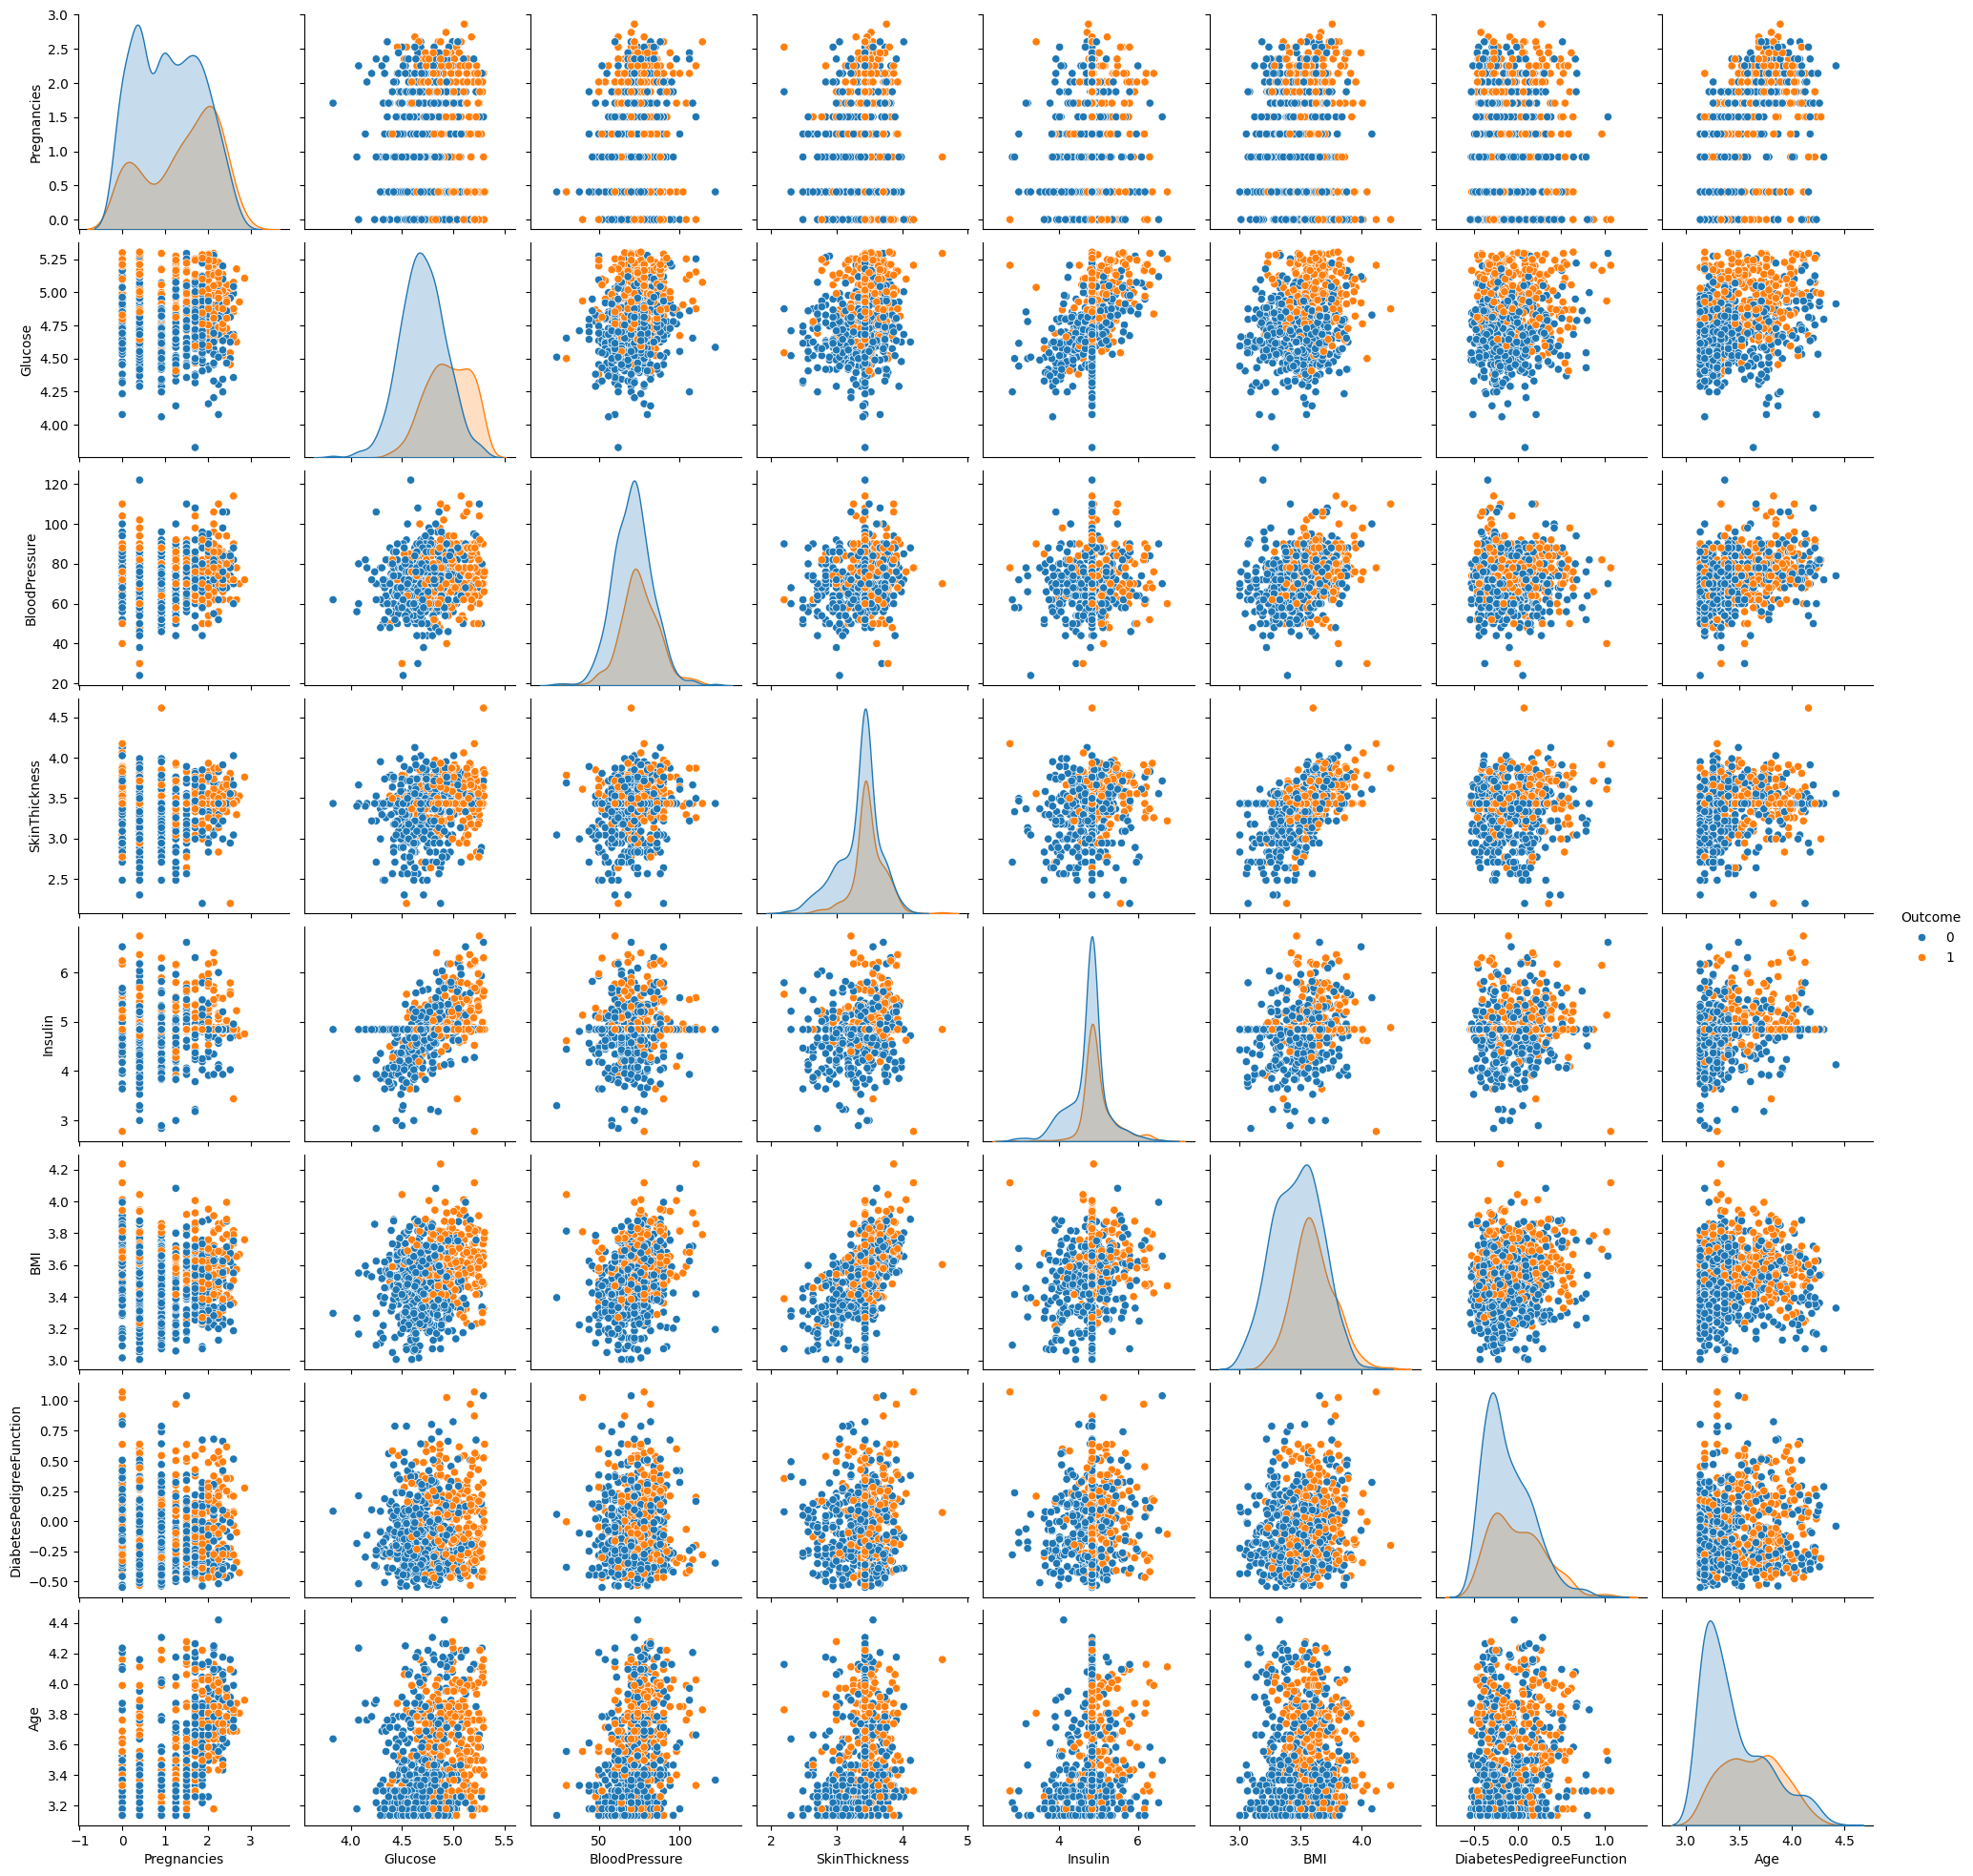

In [26]:
p=sns.pairplot(diabetes_eda, hue = 'Outcome')

Text(0.5, 1.0, 'Matrix Kolerasi Dataset Diabetes')

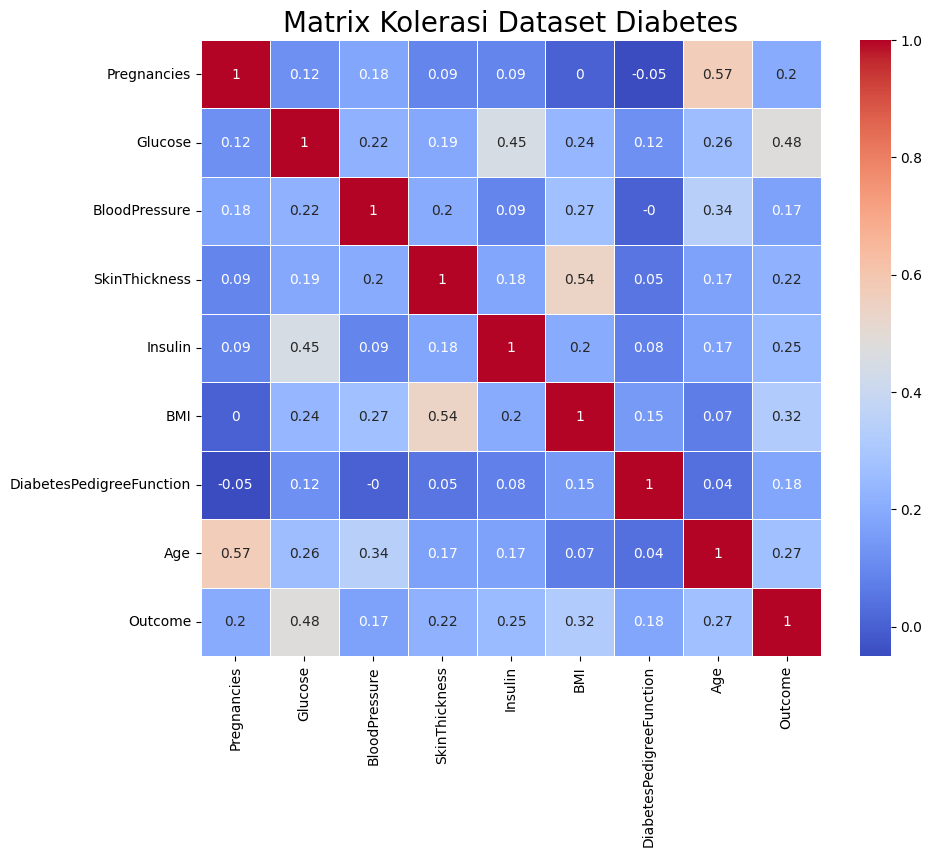

In [27]:
plt.figure(figsize=(10,8))
correlation_matrics = diabetes_eda.corr().round(2)
sns.heatmap(data=correlation_matrics, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Matrix Kolerasi Dataset Diabetes', size=20)

## Data Preparation & Model Development

Setelah proses EDA, maka dilakukan proses preparasi data lalu menuju pengembangan model prediksi machine learning. Semua proses imputasi dan transformasi data dilakukan ulang pada proses ini dan dilakukan terpisah pada data training dan data testing. Hal ini dikarenakan kita tidak ingin data testing terpapar dari value yang ada pada data training sehingga menyebabkan terjadinya data leakage. \

Dataset akan displit menjadi data training dan data testing dengan rasio 70/30 dimana 70% dari keseluruhan dataset akan dipakan sebagai data training dan sisa 30% tersebut akan digunakan sebagai data testing. \

Adapun proses transformasi yang digunakan diantaranya yaitu:
1. Imputasi menggunakan nilai median pada data dengan value NaN
2. Balancing Skewness dengan menggunakan natural logarithmic transformation menggunakan nilai $n$ sesuai pada prose EDA sebelumnya
3. Standarisasi/Scaling data
4. Melakukan oversampling pada dataset training

Proses imputasi dan balancing skewness dilakukan berdasarkan informasi parameter yang sudah didapat dari proses analisis data pada tahap EDA. Proses standarisasi dilakukan untuk memudahkan model machine learning dalam mengolah dan memahami fitur pada dataset yang digunakan. Proses oversampling pada data training dilakukan untuk mengatasi masalah imbalance label pada dataset yang digunakan.

In [28]:
X = diabetes_df.iloc[:, :-1]
y = diabetes_df.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [29]:
print(X_train.isnull().sum())

Pregnancies                   0
Glucose                       5
BloodPressure                19
SkinThickness               154
Insulin                     261
BMI                           5
DiabetesPedigreeFunction      0
Age                           0
dtype: int64


In [30]:
# apply imputation (data training)
X_train.fillna(X_train.median(), inplace=True)

# menerapkan transformasi logaritmik pada data training
X_train['Glucose'] = X_train['Glucose'].apply(lambda x: np.log(x + 2) if x > 0 else 0)
X_train['Insulin'] = X_train['Insulin'].apply(lambda x: np.log(x + 2) if x > 0 else 0)
X_train['Pregnancies'] = X_train['Pregnancies'].apply(lambda x: np.sqrt(x) if x > 0 else 0)
X_train['BMI'] = X_train['BMI'].apply(lambda x: np.log(x + 2) if x > 0 else 0)
X_train['SkinThickness'] = X_train['SkinThickness'].apply(lambda x: np.log(x + 1) if x > 0 else 0)
X_train['Age'] = X_train['Age'].apply(lambda x: np.log(x + 2) if x > 0 else 0)
X_train['DiabetesPedigreeFunction'] = X_train['DiabetesPedigreeFunction'].apply(lambda x: np.log(x + 0.5) if x > 0 else 0)

# apply imputation (data testing)
median_value = X_train.median()
X_test.fillna(median_value, inplace=True)

# menerapkan transformasi logaritmik pada data testing
X_test['Glucose'] = X_test['Glucose'].apply(lambda x: np.log(x + 2) if x > 0 else 0)
X_test['Insulin'] = X_test['Insulin'].apply(lambda x: np.log(x + 2) if x > 0 else 0)
X_test['Pregnancies'] = X_test['Pregnancies'].apply(lambda x: np.sqrt(x) if x > 0 else 0)
X_test['BMI'] = X_test['BMI'].apply(lambda x: np.log(x + 2) if x > 0 else 0)
X_test['SkinThickness'] = X_test['SkinThickness'].apply(lambda x: np.log(x + 1) if x > 0 else 0)
X_test['Age'] = X_test['Age'].apply(lambda x: np.log(x + 2) if x > 0 else 0)
X_test['DiabetesPedigreeFunction'] = X_test['DiabetesPedigreeFunction'].apply(lambda x: np.log(x + 0.5) if x > 0 else 0)

# Standarisasi training dan test set
scaler = StandardScaler()
X_trainScaled = scaler.fit_transform(X_train)
X_testScaled = scaler.transform(X_test)

# SMOTE Oversampling
smote = SMOTE(random_state=42)
X_trainFinal, y_trainFinal = smote.fit_resample(X_trainScaled, y_train)

Pada tahapan selanjutnya, akan dilakukan training dengan menggunakan beberapa algoritma yang berbeda, yaitu Logistic Regression, K Neigbors Classifier, dan Random Forest. Untuk dapat membandingkan ketiga model tersebut dan menentukan parameter terbaik dari masing - masing parameter secara bersamaan, digunakan library Grid Search CV untuk mengautomasi tugas tersebut.

In [31]:
compare_model = {
    'logistic_regression':{
        'model': LogisticRegression(solver='lbfgs', multi_class='auto'),
        'parameters': {'C':[1,5,10,20]}
    },

    'Kneighbors_classifier':{
        'model':KNeighborsClassifier(),
        'parameters': {'n_neighbors':np.arange(1,51)}
    },

    'random_forest':{
        'model': RandomForestClassifier(criterion='gini'),
        'parameters': {'n_estimators': np.arange(0,201,5)}
    }
}

scores = []

for model_name, model_params in compare_model.items():
    gs = GridSearchCV(model_params['model'], model_params['parameters'], cv = 5, return_train_score=False)
    gs.fit(X_trainFinal, y_trainFinal)
    scores.append({
        'model': model_name,
        'best_parameters': gs.best_params_,
        'score': gs.best_score_
    })

result = pd.DataFrame(scores, columns=['model','best_parameters','score'])
result

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and wi

model        best_parameters     score
0    logistic_regression              {'C': 10}  0.783720
1  Kneighbors_classifier     {'n_neighbors': 1}  0.855416
2          random_forest  {'n_estimators': 115}  0.842539

Berdasarkan hasil traning, didapatkan informasi bahwa model K Neighbors Classifier memiliki nilai akurasi terbesar, berbeda tipis dengan model Random Forest. Untuk itu pada tahapan evaluasi akan digunakan model K Neighbors Classifier dengan n_neighbors=1 sesuai dari keluaran training tersebut.

## Model Evaluation

Tahapan evaluasi model dilakukan dengan menggunakan metrik evaluasi f1-score dan juga confusion matrix. Proses ini memanfaatkan 4 buah kondisi kebenaran yaitu true positive, true negative, false positive, dan false negative. Kondisi TP terjadi apabila hasil keluaran model termasuk kedalam kelas benar atau 1 dengan keadaan sebenenarnya objek tersebut adalah benar, sedangkan FP terjadi apabila hasil keluaran model adalah benar atau 1 namun hasil sebenarnya dari objek tersebut adalah salah atau 0 sedangkan bisa disimpulkan bahwa hasil prediksi dari model tersebut tidak benar, begitu pula sebaliknya dengan kondisi TN dan FN.


K Neighbors Classifier
Accuracy: 0.68
Confusion Matrix:
 [[133  18]
 [ 55  25]]
Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.88      0.78       151
           1       0.58      0.31      0.41        80

    accuracy                           0.68       231
   macro avg       0.64      0.60      0.60       231
weighted avg       0.66      0.68      0.65       231



Text(50.722222222222214, 0.5, 'Accurate value')

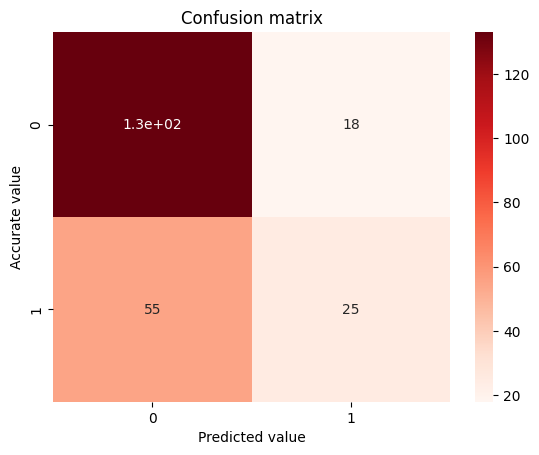

In [32]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_trainFinal, y_trainFinal)
knn_pred = knn.predict(X_testScaled)

confusionMatrix = confusion_matrix(y_test, knn_pred)

print("\nK Neighbors Classifier")
print(f"Accuracy: {accuracy_score(y_test, knn_pred):.2f}")
print("Confusion Matrix:\n", confusionMatrix)
print("Classification Report:\n", classification_report(y_test, knn_pred))

sns.heatmap(confusionMatrix, annot=True, cmap='Reds')
plt.title("Confusion matrix")
plt.xlabel('Predicted value')
plt.ylabel('Accurate value')

Dari hasil tersebut bisa terlihat bahwa meskipun sebelumnya dengan hasil training, model yang dibuat bisa menghasilkan ~80% akurasi sedangkan ketika menggunakan data testing, akurasi yang dihasilkan sulit menyentuh nilai 70%, hal ini salah satunya disebabkan karna dataset yang cukup sedikit dan juga banyaknya noise dalam dataset yang digunakan. Memperbanyak sampling data khususnya pada label 1 dan menerapkan regularization pada model linear seperti logistic regression bisa menjadi salah satu dari beberapa solusi untuk mengatasi hal ini.


Logistic Regression with Hyperparameter Tuning
Accuracy: 0.74
Confusion Matrix:
 [[119  32]
 [ 29  51]]
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.79      0.80       151
           1       0.61      0.64      0.63        80

    accuracy                           0.74       231
   macro avg       0.71      0.71      0.71       231
weighted avg       0.74      0.74      0.74       231



Text(50.722222222222214, 0.5, 'Accurate value')

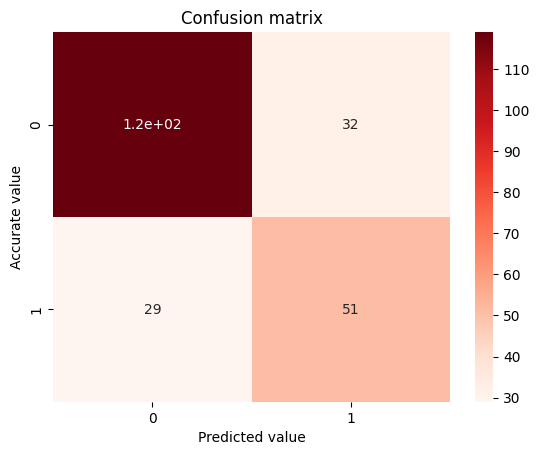

In [33]:
# Menerapkan regularization pada model logistic regression
logistic = LogisticRegression(C=10, penalty='l2', solver='lbfgs', max_iter=1000)
logistic.fit(X_trainFinal, y_trainFinal)
logistic_pred = logistic.predict(X_testScaled)

confusionMatrix = confusion_matrix(y_test, logistic_pred)

print("\nLogistic Regression with Hyperparameter Tuning")
print(f"Accuracy: {accuracy_score(y_test, logistic_pred):.2f}")
print("Confusion Matrix:\n", confusionMatrix)
print("Classification Report:\n", classification_report(y_test, logistic_pred))

sns.heatmap(confusionMatrix, annot=True, cmap='Reds')
plt.title("Confusion matrix")
plt.xlabel('Predicted value')
plt.ylabel('Accurate value')

Meski masih berada diangka ~70% akurasi, penambahan regularization pada model logistic regression menghasilkan perbaikan model yang sedikit lebih baik terutama pada nilai precision, recall, dan f1-score pada label 1 yang lebih stabil diatas 60%.